# Part 1. Clustering

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os
os.chdir(r'C:\Users\eorud\OneDrive\바탕 화면/DM')

from tqdm import notebook
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import cdist, pdist

import warnings
warnings.filterwarnings('ignore')

#### (1차)구별로 했을 때 들어가야하는 변수 => 서울시 구 별 데이터 => Clustering


1. 운행효율성, 물동량 수, 인구 수, 상권 매출액, 상권 크기, 구 별 공시지가 -> 변수 추출
2. 전처리
3. 위 변수들로 클러스터링 시 '구 별 배송 서비스 현황'을 파악 -> 클러스터 별로 MFC가 필요한지 추측
4. MFC가 가장 필요한 클러스터를 선정 -> 클러스터에 포함된 지역 파악

#### (2차) 입지 후보군(구별)에서 최적입지 선정할 때 사용되는 변수 => 서울시 주유소별 데이터 => Classification


1. 개별공시지가, 공급처 접근성(east, west, koreaDC), 면적, 주유소 기준 반경 1KM(인구 수, 학교 수, 아파트 수, 백화점 수)
2. 9개 독립변수에 근거하여 target 변수인 '입지점수(score)'를 추출
3. 입지점수를 sorting해서 상위 25% 주유소에 입지여부 1을 할당, 나머지 75% 0 할당
4. if 입지여부 = 1, 주유소는 MFC 입지에 적합, else, 주유소는 MFC 입지에 부적합
5. Decision tree, 신경망으로 분류 후 accuracy 체크

We will use some datasets, subtract required column and merge by distrcit.(Gangnam, Ganbuk, Gangdong, ...)  
First, Find the distrcit where MFC(Micro Fullfillment Center) is needed with clustering.  
Second, Set up the optimal center in district using by classification.

In [2]:
df_pop = pd.read_csv(r'주민등록인구(연령별_동별)_20221001180232.csv', encoding ='UTF8') # subtract popAll, pop2040 (population)
df_logi = pd.read_csv(r'자치구단위 월별 착지 데이터 (1).csv', encoding ='UTF8') # subtract logistics(traffic volume)
df_sales = pd.read_csv('서울시_상권_매출액.csv', encoding='euc-kr') # subtract sales & num_store
df_citycode = pd.read_csv('서울시 건축물대장 법정동 코드정보.csv', encoding='euc-kr')
df_salesarea = pd.read_csv('서울시 우리마을가게 상권분석서비스(상권영역).csv', encoding='euc-kr')
df_cjdata = pd.read_csv('CJ택배 운행량 월별 통계.csv', encoding='euc-kr') # subtract delivery distance, the number of delivery, delivery time, the number of waypoint.
df_estate = pd.read_csv(r'국토교통부_표준지공시지가_20220527.csv', encoding ='UTF8') # land value by public announcement.

This is the dataset for clustering analysis

Dataset consist of population,logistics, CJ delivery data, number of store, estate, total sales.

We will use this dataset and subtract required column and merge by distrcit. ex) Gangnam, Gangbuk, Gangdond...

## 1. Data pre-processing for clustering

In [3]:
df_pop.head(3)

,동별,항목,소계,0~4세,5~9세,10~14세,15~19세,20~24세,25~29세,30~34세,...,55~59세,60~64세,65~69세,70~74세,75~79세,80~84세,85~89세,90~94세,95~99세,100세 이상
0,종로구,계,153255,2749,4283,5013,5621,12746,14661,11200,...,12292,11791,9046,6369,5348,4282,2130,749,206,40.0
1,종로구,한국인,143624,2609,4094,4819,5357,9759,12915,10397,...,11816,11492,8913,6304,5333,4268,2122,745,206,40.0
2,종로구,외국인,9631,140,189,194,264,2987,1746,803,...,476,299,133,65,15,14,8,4,0,0.0


Population data are organized by range of age and districts

In [4]:
df_pop[df_pop['100세 이상'].isnull()]

,동별,항목,소계,0~4세,5~9세,10~14세,15~19세,20~24세,25~29세,30~34세,...,55~59세,60~64세,65~69세,70~74세,75~79세,80~84세,85~89세,90~94세,95~99세,100세 이상
74,강동구,외국인,3866,78,96,76,52,204,463,517,...,438,251,84,38,14,3,3,1,0,NaN


There is a null value the range of '100세 이상' in Gangdong-Gu, but since rare people are over 100 years old in the world, it counted with zero.

In [5]:
df_pop.loc[74, '100세 이상'] = 0
df_pop['100세 이상'] = df_pop['100세 이상'].astype(int)
df_pop[(df_pop.동별 == '강동구') & (df_pop.항목 == '외국인')]

,동별,항목,소계,0~4세,5~9세,10~14세,15~19세,20~24세,25~29세,30~34세,...,55~59세,60~64세,65~69세,70~74세,75~79세,80~84세,85~89세,90~94세,95~99세,100세 이상
74,강동구,외국인,3866,78,96,76,52,204,463,517,...,438,251,84,38,14,3,3,1,0,0


Replace the null value with 0 and change the data type to integer

In [6]:
# subtract population 20~40 
pop2040 = df_pop[df_pop.항목 =='계'][['동별', '항목', '20~24세', '25~29세', '30~34세', '35~39세', '40~44세', '45~49세']].set_index('동별').sum(axis=1)
pop2040

동별
종로구      69930
중구       61688
용산구     112398
성동구     136671
광진구     175113
동대문구    166805
중랑구     170092
성북구     199990
강북구     122596
도봉구     126118
노원구     215172
은평구     207289
서대문구    147577
마포구     191766
양천구     188467
강서구     275023
구로구     184583
금천구     111478
영등포구    192580
동작구     188778
관악구     269128
서초구     185381
강남구     247056
송파구     307780
강동구     206525
dtype: int64

According to the paper, the working age population was defined as 20-40 years old

This is working age population by districts, not all population.

In [7]:
# Logistic data by districts
df_logi.head()

,기준년월(BASE_DY),자치구(ADDR),대분류_착지물동량_가구/인테리어(E_C_01),대분류_착지물동량_기타(E_C_02),대분류_착지물동량_도서/음반(E_C_03),대분류_착지물동량_디지털/가전(E_C_04),대분류_착지물동량_생활/건강(E_C_05),대분류_착지물동량_스포츠/레저(E_C_06),대분류_착지물동량_식품(E_C_07),대분류_착지물동량_출산/육아(E_C_08),...,중분류_착지물동량_바디케어(E_C_11_04),중분류_착지물동량_베이스메이크업(E_C_11_05),중분류_착지물동량_뷰티소품(E_C_11_06),중분류_착지물동량_색조메이크업(E_C_11_07),중분류_착지물동량_선케어(E_C_11_08),중분류_착지물동량_스킨케어(E_C_11_09),중분류_착지물동량_클렌징(E_C_11_10),중분류_착지물동량_향수(E_C_11_11),중분류_착지물동량_헤어스타일링(E_C_11_12),중분류_착지물동량_헤어케어(E_C_11_13)
0,202103,강남구,25035,281991,27333,51770,198635,13054,173813,14363,...,12870,5184,5819,15549,6283,25652,9804,2174,3588,5058
1,202104,서초구,19508,259466,48374,38415,165677,17343,175048,12809,...,14142,2216,7462,3222,5000,16368,8505,1938,3307,12029
2,202105,서대문구,16904,384154,29689,46772,76597,17717,466881,14987,...,10622,4462,3432,6019,6032,18570,5389,1509,2114,11127
3,202102,강서구,46705,216690,49027,30791,292619,12504,161749,8194,...,5840,6307,6054,6159,4494,27236,7376,2187,1101,13519
4,202102,성동구,35119,240743,94856,88985,158192,16432,262624,11800,...,4759,4520,6446,7198,14554,33971,5788,1853,3256,7275


In [8]:
# sum all logistic traffic
df_logi['Total_logis'] = df_logi.iloc[:,2:].sum(axis=1)
df_logistic = df_logi[['자치구(ADDR)', 'Total_logis']]
df_logistic.rename(columns={'자치구(ADDR)' : 'District'}, inplace=True)
df_logistic.head()

,District,Total_logis
0,강남구,2439367
1,서초구,2165093
2,서대문구,2575393
3,강서구,2289581
4,성동구,2407838


Calculate the total logistics by districts

Delete columns except the data of districts and total logistics

In [9]:
#Sales dataset
df_sales.head(3)

,기준_년_코드,상권_코드,상권_코드_명,서비스_업종_코드,서비스_업종_코드_명,분기당_매출_금액,분기당_매출_건수,주중_매출_비율,주말_매출_비율,주중_매출_금액,주말_매출_금액,남성_매출_금액,여성_매출_금액,주중_매출_건수,주말_매출_건수,점포수
0,2021,2110001,이북5도청사,CS100001,한식음식점,626851391.0,25502,59,41,367617856.0,259233535.0,369379103.0,168952823.0,16355,9147,28
1,2021,2110001,이북5도청사,CS100008,분식전문점,122957138.0,12039,50,50,61070094.0,61887044.0,64010667.0,47678846.0,6435,5604,9
2,2021,2110001,이북5도청사,CS100009,호프-간이주점,5093349.0,177,62,38,3135732.0,1957617.0,3428046.0,1186972.0,106,71,3


In [10]:
df_sales2 = df_sales[['상권_코드', '분기당_매출_금액', '점포수']].groupby('상권_코드').sum().reset_index()
df_sales2.head()

,상권_코드,분기당_매출_금액,점포수
0,1001491,3.444003e+11,6069
1,1001492,1.351039e+12,30461
2,1001493,8.348820e+11,47638
3,1001494,9.341597e+11,19614
4,1001495,6.100271e+11,7811


Delete columns except the data of commercial code, quarterly sales, number of stores from sales dataset

In [11]:
#Extract only commercial and district code for merge
df_salesarea2 = df_salesarea[['상권_코드', '시군구_코드']]
df_salesarea2.head()

,상권_코드,시군구_코드
0,2110753,11545
1,2110427,11350
2,2110755,11545
3,2110739,11545
4,2111017,11710


In [12]:
#Merge by commercial code
df_salesmerge = pd.merge(df_sales2, df_salesarea2)
df_salesmerge.head()

,상권_코드,분기당_매출_금액,점포수,시군구_코드
0,1001491,3.444003e+11,6069,11170
1,1001492,1.351039e+12,30461,11140
2,1001493,8.348820e+11,47638,11140
3,1001494,9.341597e+11,19614,11110
4,1001495,6.100271e+11,7811,11710


In [13]:
#Extract only district code and district name for to know the name of districs
#And remove duplicated data
df_citycode2 = df_citycode[['시군구코드', '시군구명']].drop_duplicates()
df_citycode2.head()

,시군구코드,시군구명
0,41610,광주시
14,36110,NaN
24,30170,서구
25,26710,기장군
53,41281,고양시 덕양구


In [14]:
#Now we can match commercial code with the district name by using district code
df_citysalesmerge = pd.merge(df_salesmerge, df_citycode2, left_on='시군구_코드', right_on='시군구코드')
df_citysalesmerge.head()

,상권_코드,분기당_매출_금액,점포수,시군구_코드,시군구코드,시군구명
0,1001491,3.444003e+11,6069,11170,11170,용산구
1,2110058,3.433195e+10,922,11170,11170,용산구
2,2110059,8.823601e+09,424,11170,11170,용산구
3,2110060,1.870217e+10,636,11170,11170,용산구
4,2110061,7.722694e+09,233,11170,11170,용산구


In [15]:
df_sales_store = df_citysalesmerge.groupby('시군구명')[['분기당_매출_금액', '점포수']].sum()
df_sales_store.reset_index(inplace=True)
df_sales_store.head()

,시군구명,분기당_매출_금액,점포수
0,강남구,1.186065e+13,186288
1,강동구,2.749058e+12,78406
2,강북구,1.482913e+12,48726
3,강서구,2.842142e+12,76835
4,관악구,2.168390e+12,70236


Now we calculated the quarterly sales and the number of stores by districts

In [16]:
#CJ delivery dataset
df_cjdata.head(3)

,운행년월(DRIVEN_YM),주소(구)(ADDR),운행거리(평균)(DRIVEN_AVR),운행거리(총거리)(DRIVEN_SUM),운행대수(DRIVEN_CNT),운행_총시간(DRIVEN_TIME),경유지_총건수(VIA_CNT),데이터_생성_일시(ETL_INS_DT),데이터_업데이트_일시(ETL_UPD_DT)
0,202011,동대문,10.706256,52579.968458,7122,109180824,402530,2021-07-26 08:45:36.0000000,2021-07-26 08:45:36.0000000
1,202006,용산구,12.758485,85058.221296,3671,66316795,375971,2021-07-26 08:45:36.0000000,2021-07-26 08:45:36.0000000
2,202007,구로구,12.307220,76255.048379,5280,79544164,299260,2021-07-26 08:45:36.0000000,2021-07-26 08:45:36.0000000


In [17]:
#Rename CJ delivery dataset and delete unused columns
df_cjdata.columns = ['DRIVEN_YM', 'ADDR', 'DRIVEN_AVR', 'DRIVEN_SUM', 'DRIVEN_CNT', 'DRIVEN_TIME', 'VIA_CNT', 'ETL_INS_DT', 'ETL_UPD_DT']
df_subcjdata = df_cjdata.drop(['DRIVEN_YM', 'ETL_INS_DT', 'ETL_UPD_DT'], axis=1)

In [18]:
#Rename the rows. Because the dataset mark 'Dongdaemun' not 'Dongdaemun-Gu'
df_subcjdata.loc[0,'ADDR'] = '동대문구'
df_subcjdata.loc[10,'ADDR'] = '영등포구'
df_subcjdata.loc[17,'ADDR'] = '서대문구'
df_subcjdata.head()

,ADDR,DRIVEN_AVR,DRIVEN_SUM,DRIVEN_CNT,DRIVEN_TIME,VIA_CNT
0,동대문구,10.706256,52579.968458,7122,109180824,402530
1,용산구,12.758485,85058.221296,3671,66316795,375971
2,구로구,12.307220,76255.048379,5280,79544164,299260
3,노원구,12.789262,54740.653719,5592,142538008,386235
4,서초구,14.762646,96238.630233,6675,49820104,551835


In [19]:
# There are so many variables related to driving, so we make a derivable attribute
df_subcjdata['driven_eff'] = (df_subcjdata.DRIVEN_SUM / df_subcjdata.DRIVEN_TIME) * (df_subcjdata.VIA_CNT / df_subcjdata.DRIVEN_CNT)

$$ Driven Efficiency = (\frac{DRIVEN SUM}{DRIVEN TIME}) * (\frac{VIA CNT}{DRIVEN CNT})  $$

- 소비자 입장에서 지역(구)의 운행효율성(Driven_Efficiency)이 크다면 -> 다른 지역에 비해 이미 빠른 배송을 받고 있다 -> MFC 수요가 적을 것이다 

First, Sum of driven distance divided by Sum of driven time. This value means velocity.

Second, Number of vehicles divided by Sum of stopovers. The higher vlaue the higher efficiency.

Finally, mulityply value of first and second.

It is also the higher value the higher driving efficiency

In [20]:
#Leaving only obtained derivable attribute and districts
df_subcjdata.drop(['DRIVEN_AVR', 'DRIVEN_SUM', 'DRIVEN_CNT', 'DRIVEN_TIME', 'VIA_CNT'], axis=1, inplace=True)
df_subcjdata.head()

,ADDR,driven_eff
0,동대문구,0.027219
1,용산구,0.131360
2,구로구,0.054334
3,노원구,0.026526
4,서초구,0.159699


In [21]:
#Estate dataset
df_estate.head()

,일련번호,시군구,읍면동리,지번구분,본번지,부번지,시도명,시군구명,소재지,지목,...,용도지역2,이용상황,주위환경,지세명,형상명,도로교통,공시지가,지리적위치1,지리적위치2,방위
0,1,11110,10100,1,3,52,서울특별시,종로구,청운동 3-52,공원,...,NaN,공원등,시가지주변 야산지대,급경사지,부정형,세로(불),493500,경기상고,북측 인근,NaN
1,2,11110,10100,1,4,2,서울특별시,종로구,청운동 4-2,임야,...,NaN,자연림,시가지주변 야산지대,완경사지,부정형,맹지,730500,경가상고,북서측 근거리,남향
2,3,11110,10100,1,4,15,서울특별시,종로구,청운동 4-15,대,...,NaN,단독주택,기존 주택지대,완경사지,사다리형,세로(가),4250000,경기상고,북서측 인근,북동향
3,4,11110,10100,1,8,9,서울특별시,종로구,청운동 8-9,대,...,NaN,연립주택,일반 주택지대,급경사지,부정형,세로(가),3930000,청운중학교,서측인근,남향
4,5,11110,10100,1,8,15,서울특별시,종로구,청운동 8-15,대,...,NaN,연립주택,기존 주택지대,급경사지,사다리형,세로(가),3855000,경기상고,서측인근,남서향


In [22]:
#Extract only district, address and extent in Seoul
df_area=df_estate[df_estate['시도명']=='서울특별시']
df_area[['시도명','시군구명','소재지','면적']].head()

,시도명,시군구명,소재지,면적
0,서울특별시,종로구,청운동 3-52,1021.5
1,서울특별시,종로구,청운동 4-2,723.3
2,서울특별시,종로구,청운동 4-15,416.2
3,서울특별시,종로구,청운동 8-9,811.3
4,서울특별시,종로구,청운동 8-15,442.3


In [23]:
# Land value in Seoul by districts(unit:1000)
estate = df_estate[df_estate['시도명']=='서울특별시'].groupby('시군구명').공시지가.mean().round(-3).astype(int)
estate

시군구명
강남구     17385000
강동구      5986000
강북구      3705000
강서구      4485000
관악구      5826000
광진구      6014000
구로구      4109000
금천구      3870000
노원구      3911000
도봉구      3451000
동대문구     5198000
동작구      6095000
마포구      9213000
서대문구     5936000
서초구     11141000
성동구      6744000
성북구      4507000
송파구      8497000
양천구      4634000
영등포구     6240000
용산구     10079000
은평구      4391000
종로구      9841000
중구      14812000
중랑구      4089000
Name: 공시지가, dtype: int32

In [24]:
#Consolidate the data obtained above
df_table = pd.merge(df_subcjdata, df_sales_store, left_on='ADDR', right_on='시군구명').merge(df_logistic, left_on ='ADDR', right_on='District')
df_table.head()

,ADDR,driven_eff,시군구명,분기당_매출_금액,점포수,District,Total_logis
0,동대문구,0.027219,동대문구,4.447564e+12,66655,동대문구,2400374
1,용산구,0.131360,용산구,6.805869e+12,62840,용산구,2250955
2,구로구,0.054334,구로구,2.806535e+12,69651,구로구,2442377
3,노원구,0.026526,노원구,1.834499e+12,57391,노원구,2507172
4,서초구,0.159699,서초구,6.456707e+12,117682,서초구,2165093


In [25]:
#Add columns about population and land value
df_table['pop2040'] = df_table.ADDR.map(pop2040)
# df_table['popALL'] = df_table.ADDR.map(popALL)
df_table['estate'] = df_table.ADDR.map(estate)
df_table.head()

,ADDR,driven_eff,시군구명,분기당_매출_금액,점포수,District,Total_logis,pop2040,estate
0,동대문구,0.027219,동대문구,4.447564e+12,66655,동대문구,2400374,166805,5198000
1,용산구,0.131360,용산구,6.805869e+12,62840,용산구,2250955,112398,10079000
2,구로구,0.054334,구로구,2.806535e+12,69651,구로구,2442377,184583,4109000
3,노원구,0.026526,노원구,1.834499e+12,57391,노원구,2507172,215172,3911000
4,서초구,0.159699,서초구,6.456707e+12,117682,서초구,2165093,185381,11141000


In [26]:
#Remove the duplicated columns and rename the columns and change the order of columns
df_table.drop(['시군구명', 'ADDR'], axis=1, inplace=True)
df_table.rename(columns={'분기당_매출_금액' : 'Total_sales', '점포수' : 'Num_store'}, inplace=True)
df_table = df_table[['District', 'driven_eff', 'Total_logis', 'pop2040', 'Total_sales', 'Num_store', 'estate']]
df_table.columns = df_table.columns.str.upper()
df_table.head()

,DISTRICT,DRIVEN_EFF,TOTAL_LOGIS,POP2040,TOTAL_SALES,NUM_STORE,ESTATE
0,동대문구,0.027219,2400374,166805,4.447564e+12,66655,5198000
1,용산구,0.131360,2250955,112398,6.805869e+12,62840,10079000
2,구로구,0.054334,2442377,184583,2.806535e+12,69651,4109000
3,노원구,0.026526,2507172,215172,1.834499e+12,57391,3911000
4,서초구,0.159699,2165093,185381,6.456707e+12,117682,11141000


#### This is the result of data pre-processing by districts

### Choose the district where MFC is required. (for clustering)

In [27]:
#Data processing for scaling
col_name = df_table.columns.drop(['DISTRICT']).to_list()
df_scaling = df_table[col_name]
df_scaling.head()

,DRIVEN_EFF,TOTAL_LOGIS,POP2040,TOTAL_SALES,NUM_STORE,ESTATE
0,0.027219,2400374,166805,4.447564e+12,66655,5198000
1,0.131360,2250955,112398,6.805869e+12,62840,10079000
2,0.054334,2442377,184583,2.806535e+12,69651,4109000
3,0.026526,2507172,215172,1.834499e+12,57391,3911000
4,0.159699,2165093,185381,6.456707e+12,117682,11141000


In [28]:
#오렌지 해보기
df_scaling.to_csv(r'results.csv')

In [29]:
# StandardScalaer
from sklearn.preprocessing import StandardScaler
s_scaler = StandardScaler()
s_scaled = s_scaler.fit_transform(df_scaling)
# This dataset is after scaling
pd.DataFrame(s_scaled, columns=col_name)

,DRIVEN_EFF,TOTAL_LOGIS,POP2040,TOTAL_SALES,NUM_STORE,ESTATE
0,-1.136150,0.227904,-0.197550,0.290781,-0.345691,-0.461560
1,1.346835,-0.703058,-1.124559,1.234272,-0.450148,0.939167
2,-0.489647,0.489605,0.105360,-0.365747,-0.263659,-0.774076
3,-1.152681,0.893314,0.626548,-0.754631,-0.599345,-0.830897
4,2.022516,-1.238025,0.118956,1.094582,1.051459,1.243935
5,1.619030,-1.844450,0.227747,0.146777,0.563181,0.690647
6,0.175537,0.754410,0.367871,-0.936204,-0.724118,-0.659860
7,-1.359439,-1.001981,-0.950802,-0.895290,-0.836598,-0.890014
8,0.882044,-2.049242,-0.890792,-1.004296,-1.054000,-0.962906
9,-0.208040,-1.009894,-1.140235,-0.092175,-0.650464,-0.842663


In [30]:
#PCA for data reduction
from sklearn.decomposition import PCA
pca = PCA(n_components=6) 
values_pca = pca.fit_transform(s_scaled)
principalDf = pd.DataFrame(data=values_pca, columns = ['PC1', 'PC2','PC3', 'PC4', 'PC5', 'PC6'])
principalDf.head()

,PC1,PC2,PC3,PC4,PC5,PC6
0,-0.484454,-0.823491,0.285771,0.790487,0.377218,-0.192964
1,1.235587,1.702674,0.624046,0.020308,1.163901,0.103416
2,-0.893321,-0.611083,0.128440,-0.021362,-0.072842,-0.315191
3,-1.456038,-1.414561,-0.074750,-0.067021,-0.066145,0.053230
4,2.276727,1.853433,-0.770652,-0.513856,0.034141,-0.103255


In [31]:
# Output results from PCA (explained variance and ratio, cumulative ratio)
print('Explained variance ratio :', pca.explained_variance_ratio_)
pca_ratio = pd.DataFrame({'Explained variance':pca.explained_variance_,
             'Explained variance ratio':pca.explained_variance_ratio_},
            index=np.array([f"PCA{num+1}" for num in range(s_scaled.shape[1])]))
pca_ratio['Cumulative ratio'] = pca_ratio['Explained variance ratio'].cumsum()
pca_ratio

Explained variance ratio : [0.4736976  0.25002054 0.16547079 0.08416489 0.02014256 0.00650362]


,Explained variance,Explained variance ratio,Cumulative ratio
PCA1,2.960610,0.473698,0.473698
PCA2,1.562628,0.250021,0.723718
PCA3,1.034192,0.165471,0.889189
PCA4,0.526031,0.084165,0.973354
PCA5,0.125891,0.020143,0.993496
PCA6,0.040648,0.006504,1.000000


We choose the number of pca that Explained variance is more than 0.7 and culmuative ratio is over 80%.  
So, up to PCA3 is suitable.

In [32]:
# The explained variance described by the PCA3
pca = PCA(n_components=3) 
values_pca = pca.fit_transform(s_scaled)
principalDf = pd.DataFrame(data=values_pca, columns = ['PC1', 'PC2', 'PC3'])
print('Explained variance ratio :', pca.explained_variance_ratio_)

Explained variance ratio : [0.4736976  0.25002054 0.16547079]


In [33]:
principalDf.head()

,PC1,PC2,PC3
0,-0.484454,-0.823491,0.285771
1,1.235587,1.702674,0.624046
2,-0.893321,-0.611083,0.128440
3,-1.456038,-1.414561,-0.074750
4,2.276727,1.853433,-0.770652


## 2. Clustering (AGNES, k-means, k-medoid, GMM)

### Hierarchy Clustering (AGNES)

In [34]:
import matplotlib
matplotlib.rcParams['font.family'] ='Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False

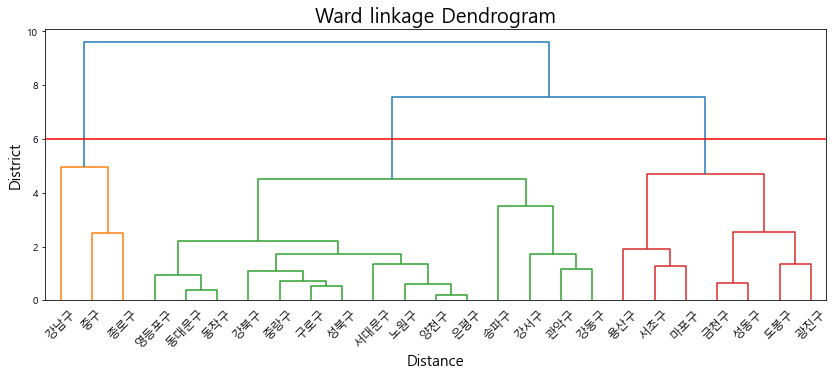

In [35]:
#Dendrogram
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

plt.figure(figsize=(14, 5))
ax = plt.subplot(111)
dendrogram(linkage(values_pca, method='ward', metric = 'euclidean'), labels = df_table['DISTRICT'].values, leaf_font_size=12)
plt.axhline(y = 6, color = 'red') 
plt.title('Ward linkage Dendrogram', size=20)
plt.xlabel('Distance', size=15)
plt.ylabel('District', size=15)
plt.show()

Using Ward method, We can cluster for 3 groups.
- 강남구, 중구, 종로구(CLUSTER=0)
- 영등포구, 동대문구, 동작구, 강북구, 중랑구, 구로구, 성북구, 서대문구, 노원구, 양천구, 은평구, 송파구, 강서구, 관악구, 강동구(CLUSTER=1)
- 용산구, 서초구, 마포구, 금천구, 성동구, 도봉구, 광진구(CLUSTER=2)

In [36]:
#Cluster group numbering for each districts
df_hcluster = df_table.copy()
df_hcluster['CLUSTER'] = 0
list1 = ['영등포구', '동대문구', '동작구', '강북구', '중랑구', '구로구', '성북구', '서대문구', '노원구', '양천구', '은평구', '송파구', '강서구', '관악구', '강동구']
list2 = ['용산구', '서초구', '마포구', '금천구', '성동구', '도봉구', '광진구']
df_hcluster.loc[df_hcluster['DISTRICT'].isin(list1), 'CLUSTER'] = 1
df_hcluster.loc[df_hcluster['DISTRICT'].isin(list2), 'CLUSTER'] = 2
df_hcluster

,DISTRICT,DRIVEN_EFF,TOTAL_LOGIS,POP2040,TOTAL_SALES,NUM_STORE,ESTATE,CLUSTER
0,동대문구,0.027219,2400374,166805,4.447564e+12,66655,5198000,1
1,용산구,0.131360,2250955,112398,6.805869e+12,62840,10079000,2
2,구로구,0.054334,2442377,184583,2.806535e+12,69651,4109000,1
3,노원구,0.026526,2507172,215172,1.834499e+12,57391,3911000,1
4,서초구,0.159699,2165093,185381,6.456707e+12,117682,11141000,2
5,마포구,0.142776,2067762,191766,4.087616e+12,99849,9213000,2
6,성북구,0.082233,2484878,199990,1.380648e+12,52834,4507000,1
7,강북구,0.017854,2202978,122596,1.482913e+12,48726,3705000,1
8,도봉구,0.111866,2034893,126118,1.210447e+12,40786,3451000,2
9,금천구,0.066146,2201708,111478,3.490343e+12,55524,3870000,2


In [37]:
hcluster0 = df_hcluster[df_hcluster['CLUSTER'] == 0]
hcluster1 = df_hcluster[df_hcluster['CLUSTER'] == 1]
hcluster2 = df_hcluster[df_hcluster['CLUSTER'] == 2]

Text(0.5, 1.0, 'ESTATE')

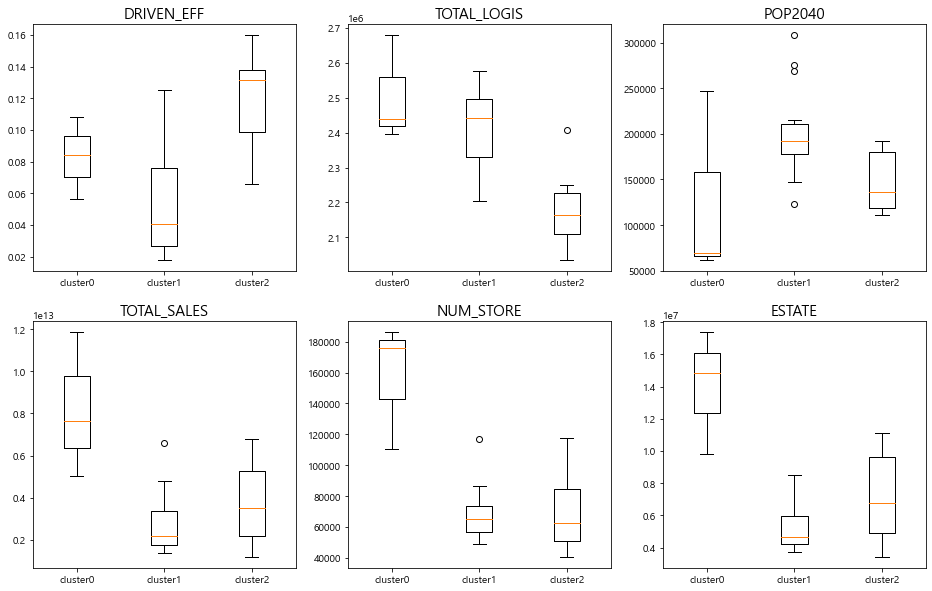

In [38]:
# Boxplot each attributes by clustering group

fig = plt.figure(figsize=(16,10))
ax1 = fig.add_subplot(2,3,1)
ax2 = fig.add_subplot(2,3,2)
ax3 = fig.add_subplot(2,3,3)
ax4 = fig.add_subplot(2,3,4)
ax5 = fig.add_subplot(2,3,5)
ax6 = fig.add_subplot(2,3,6)




ax1.boxplot([hcluster0.DRIVEN_EFF, hcluster1.DRIVEN_EFF, hcluster2.DRIVEN_EFF], labels=['cluster0','cluster1','cluster2']) # DRIVEN_EFF(평균 주행거리) 비교
ax1.set_title('DRIVEN_EFF', size=15)
ax2.boxplot([hcluster0.TOTAL_LOGIS, hcluster1.TOTAL_LOGIS, hcluster2.TOTAL_LOGIS], labels=['cluster0','cluster1','cluster2'])# TOTAL_LOGIS 비교
ax2.set_title('TOTAL_LOGIS', size=15)
ax3.boxplot([hcluster0.POP2040, hcluster1.POP2040, hcluster2.POP2040], labels=['cluster0','cluster1','cluster2'])# POP2040 비교
ax3.set_title('POP2040', size=15)
ax4.boxplot([hcluster0.TOTAL_SALES, hcluster1.TOTAL_SALES, hcluster2.TOTAL_SALES], labels=['cluster0','cluster1','cluster2'])# TOTAL_SALES 비교
ax4.set_title('TOTAL_SALES', size=15)
ax5.boxplot([hcluster0.NUM_STORE, hcluster1.NUM_STORE, hcluster2.NUM_STORE], labels=['cluster0','cluster1','cluster2'])# NUM_STORE 비교
ax5.set_title('NUM_STORE', size=15)
ax6.boxplot([hcluster0.ESTATE, hcluster1.ESTATE, hcluster2.ESTATE], labels=['cluster0','cluster1','cluster2'])# ESTATE 비교
ax6.set_title('ESTATE', size=15)

## Hierarchy Clustering Analysis Result

- cluster0
    - 물류량이 가장 많으며 우수한 소비력과 대규모 상권
    - 물류 수요량이 많지만 상권도 크기 때문에 언택트 소비가 작을 것으로 예상됨
    - 인구수가 적으므로 수요증가량을 기대하기 어려움
    - 공시지가가 가장 크다 -> MFC 입지에 부적합
    
- cluster1
    - 물류량 및 인구수 준수함
    - 소규모 상권, 오프라인 소비력이 높기 때문에 언택스 소비량이 클 것이라고 예상할 수 있음
    - 공시지가와 운행 효율이 낮음 -> MFC 입지에 적합
    
- cluster2
    - 공시지가는 높지 않음
    - 하지만 물류량은 가장 낮으면서 운행 효율이 가장 높기 때문에 이미 물류 서비스율이 높다고 할 수 있음 -> MFC 입지에 부적합

#### 따라서 cluster1이 MFC 입지에 가장 적합

In [39]:
# Extract the appropriate district name for MFC location
hcluster1.DISTRICT.unique()

array(['동대문구', '구로구', '노원구', '성북구', '강북구', '영등포구', '중랑구', '관악구', '양천구',
       '서대문구', '송파구', '강서구', '강동구', '동작구', '은평구'], dtype=object)

### K-means Clustering

In [40]:
# https://github.com/blings0611/Finding-New-Location-of-Wheel-Chair-Charging-Station/blob/master/2.%20CLUSTERING/BARRIER_FREE_FINAL.ipynb
from sklearn.cluster import KMeans
def elbow_method(data):
    K = range(1,8) 
    KM = [KMeans(n_clusters=k, random_state=100).fit(data) for k in K] 
    centroids = [k.cluster_centers_ for k in KM] 
    D_k = [cdist(data, cent, 'euclidean') for cent in centroids] 
    cIdx = [np.argmin(D,axis=1) for D in D_k]
    dist = [np.min(D,axis=1) for D in D_k]
    avgWithinSS = [sum(d)/data.shape[0] for d in dist]

    # Total with-in sum of square
    wcss = [sum(d**2) for d in dist]
    tss = sum(pdist(data)**2)/data.shape[0]
    bss = tss-wcss
    

    # Elbow curve
    fig = plt.figure() 
    ax = fig.add_subplot(111)
    
    kIdx = 2
    ax.plot(K, avgWithinSS, 'b*-')
    ax.plot(K[kIdx], avgWithinSS[kIdx], marker='o', markersize=15, 
    markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
    
    kIdx = 3
    ax.plot(K, avgWithinSS, 'b*-')
    ax.plot(K[kIdx], avgWithinSS[kIdx], marker='o', markersize=10, 
    markeredgewidth=2, markeredgecolor='b', markerfacecolor='None')
    
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Average within-cluster sum of squares')
    plt.title('Elbow for K-Means clustering')

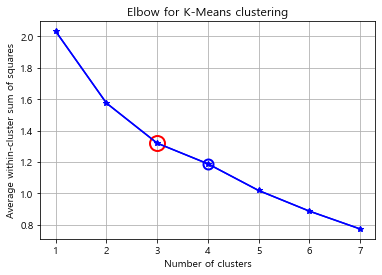

In [41]:
# Use the elbow method to know the value of k
elbow_method(values_pca)

According to elbow method and dendrogram we select number 3 as the number of groups.

In [43]:
kmeans = KMeans(init='k-means++', n_clusters=3, random_state=100) # Opitmal K = 3
kmeans.fit(values_pca)

KMeans(n_clusters=3, random_state=100)

In [44]:
# pca values only first column (pc1)
values_pca[:,0]

array([-0.4844543 ,  1.23558748, -0.89332056, -1.45603787,  2.27672684,
        1.08688862, -1.30673585, -1.6854964 , -1.53369094, -0.91053517,
        0.06187967, -1.29107118, -0.47666988, -0.34740124,  5.15454057,
        3.77613727, -1.13745788, -1.20058391,  1.25466409, -0.77584858,
       -0.26596698,  1.41516297, -0.86347716, -0.38623549, -1.24660413])

In [45]:
principalDf['DISTRICT'] = df_table['DISTRICT']
principalDf.head()

,PC1,PC2,PC3,DISTRICT
0,-0.484454,-0.823491,0.285771,동대문구
1,1.235587,1.702674,0.624046,용산구
2,-0.893321,-0.611083,0.128440,구로구
3,-1.456038,-1.414561,-0.074750,노원구
4,2.276727,1.853433,-0.770652,서초구


In [46]:
#k-means cluster centers for plot
kmeans.cluster_centers_

array([[-0.76846774, -0.49049657, -0.08311051],
       [ 0.54362215,  1.98585984, -0.43179779],
       [ 3.44861361, -0.53028583,  1.19062254]])

In [47]:
kmeans.cluster_centers_[:2, 0]

array([-0.76846774,  0.54362215])

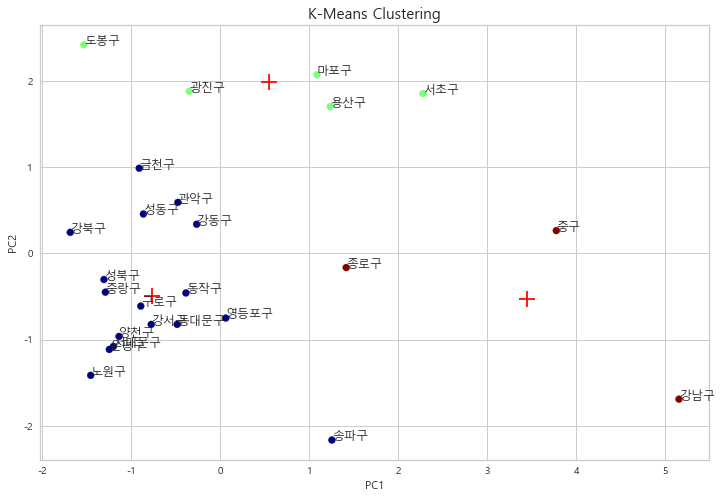

In [48]:
# Kmeans visulaization
# The center of each cluster is marked with +

matplotlib.rcParams['font.family'] ='Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(12,8))
plt.scatter(values_pca[:,0], values_pca[:,1], c=kmeans.labels_, cmap='jet')
plt.scatter(kmeans.cluster_centers_[:3, 0], kmeans.cluster_centers_[:3, 1], s=250, marker='+', c='red', edgecolor='black',
    label='centroids'
)
for i in range(len(principalDf)): 
    row = principalDf.iloc[i]
    name = row['DISTRICT'] 
    x = row['PC1'] 
    y = row['PC2'] 

    plt.text(x, y, name, size=12)
plt.title('K-Means Clustering', size=15)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()


- '동대문구', '구로구', '노원구', '성북구', '강북구', '금천구', '영등포구', '중랑구', '관악구','양천구', '서대문구', '송파구', '강서구', '강동구', '성동구', '동작구', '은평구(CLUSTER=0)
- 도봉구, 광진구, 마포구, 용산구, 서초구(CLUSTER=1)
- 강남구, 중구, 종로구(CLUSTER=2)

In [49]:
kmeans.labels_

array([0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 2,
       0, 0, 0])

In [50]:
#Cluster group numbering for each districts
df_ktable = df_table.copy()
df_ktable['CLUSTER']=kmeans.labels_
df_ktable

,DISTRICT,DRIVEN_EFF,TOTAL_LOGIS,POP2040,TOTAL_SALES,NUM_STORE,ESTATE,CLUSTER
0,동대문구,0.027219,2400374,166805,4.447564e+12,66655,5198000,0
1,용산구,0.131360,2250955,112398,6.805869e+12,62840,10079000,1
2,구로구,0.054334,2442377,184583,2.806535e+12,69651,4109000,0
3,노원구,0.026526,2507172,215172,1.834499e+12,57391,3911000,0
4,서초구,0.159699,2165093,185381,6.456707e+12,117682,11141000,1
5,마포구,0.142776,2067762,191766,4.087616e+12,99849,9213000,1
6,성북구,0.082233,2484878,199990,1.380648e+12,52834,4507000,0
7,강북구,0.017854,2202978,122596,1.482913e+12,48726,3705000,0
8,도봉구,0.111866,2034893,126118,1.210447e+12,40786,3451000,1
9,금천구,0.066146,2201708,111478,3.490343e+12,55524,3870000,0


In [51]:
kcluster0 = df_ktable[df_ktable['CLUSTER'] == 0]
kcluster1 = df_ktable[df_ktable['CLUSTER'] == 1]
kcluster2 = df_ktable[df_ktable['CLUSTER'] == 2]

Text(0.5, 1.0, 'ESTATE')

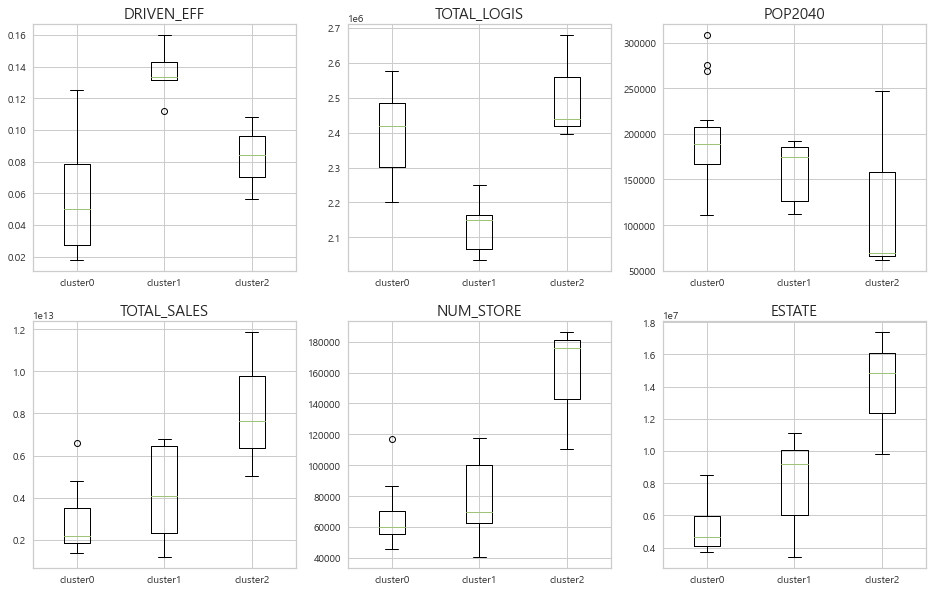

In [52]:
# Boxplot each attributes by clustering group

fig = plt.figure(figsize=(16,10))
ax1 = fig.add_subplot(2,3,1)
ax2 = fig.add_subplot(2,3,2)
ax3 = fig.add_subplot(2,3,3)
ax4 = fig.add_subplot(2,3,4)
ax5 = fig.add_subplot(2,3,5)
ax6 = fig.add_subplot(2,3,6)




ax1.boxplot([kcluster0.DRIVEN_EFF, kcluster1.DRIVEN_EFF, kcluster2.DRIVEN_EFF], labels=['cluster0','cluster1','cluster2']) # DRIVEN_EFF 비교
ax1.set_title('DRIVEN_EFF', size=15)
ax2.boxplot([kcluster0.TOTAL_LOGIS, kcluster1.TOTAL_LOGIS, kcluster2.TOTAL_LOGIS], labels=['cluster0','cluster1','cluster2'])# TOTAL_LOGIS 비교
ax2.set_title('TOTAL_LOGIS', size=15)
ax3.boxplot([kcluster0.POP2040, kcluster1.POP2040, kcluster2.POP2040], labels=['cluster0','cluster1','cluster2'])# POP2040 비교
ax3.set_title('POP2040', size=15)
ax4.boxplot([kcluster0.TOTAL_SALES, kcluster1.TOTAL_SALES, kcluster2.TOTAL_SALES], labels=['cluster0','cluster1','cluster2'])# TOTAL_SALES 비교
ax4.set_title('TOTAL_SALES', size=15)
ax5.boxplot([kcluster0.NUM_STORE, kcluster1.NUM_STORE, kcluster2.NUM_STORE], labels=['cluster0','cluster1','cluster2'])# NUM_STORE 비교
ax5.set_title('NUM_STORE', size=15)
ax6.boxplot([kcluster0.ESTATE, kcluster1.ESTATE, kcluster2.ESTATE], labels=['cluster0','cluster1','cluster2'])# ESTATE 비교
ax6.set_title('ESTATE', size=15)

## K-means Clustering Analysis Result
- cluster0
    - 물류량이 및 인구수 준수 
    - 인구수는 많지만 상권 크기가 작아 언택트 소비 증가를 기대할 수 있음
    - 공시지가 및 운행 효율이 가장 낮음 -> MFC 입지에 적합

- cluster1
    - 물류량이 가장 작음 
    - 하지만 운행 효율이 가장 높기 때문에 이미 물류 서비스율이 높다고 할 수 있음 -> MFC입지에 부적합
 
- cluster2 
    - 물류량이 가장 많음
    - 인구수 대비 가장 높은 상권과 소비력
    - 하지만 공시지가가 너무 높음 -> MFC입지에 부적합

#### 따라서 cluster0이 MFC 입지에 가장 적합

In [53]:
# Extract the appropriate district name for MFC location
kcluster0.DISTRICT.unique()

array(['동대문구', '구로구', '노원구', '성북구', '강북구', '금천구', '영등포구', '중랑구', '관악구',
       '양천구', '서대문구', '송파구', '강서구', '강동구', '성동구', '동작구', '은평구'],
      dtype=object)

### K-medoid Clustering

In [54]:
from sklearn_extra.cluster import KMedoids
kmedoids = KMedoids(n_clusters=3, random_state=100).fit(values_pca)

In [55]:
# Using k-medoid clusterin (k=3)
df_k2table = df_table.copy()
df_k2table['CLUSTER'] = kmedoids.labels_
df_k2table

,DISTRICT,DRIVEN_EFF,TOTAL_LOGIS,POP2040,TOTAL_SALES,NUM_STORE,ESTATE,CLUSTER
0,동대문구,0.027219,2400374,166805,4.447564e+12,66655,5198000,2
1,용산구,0.131360,2250955,112398,6.805869e+12,62840,10079000,0
2,구로구,0.054334,2442377,184583,2.806535e+12,69651,4109000,2
3,노원구,0.026526,2507172,215172,1.834499e+12,57391,3911000,1
4,서초구,0.159699,2165093,185381,6.456707e+12,117682,11141000,0
5,마포구,0.142776,2067762,191766,4.087616e+12,99849,9213000,0
6,성북구,0.082233,2484878,199990,1.380648e+12,52834,4507000,1
7,강북구,0.017854,2202978,122596,1.482913e+12,48726,3705000,1
8,도봉구,0.111866,2034893,126118,1.210447e+12,40786,3451000,0
9,금천구,0.066146,2201708,111478,3.490343e+12,55524,3870000,0


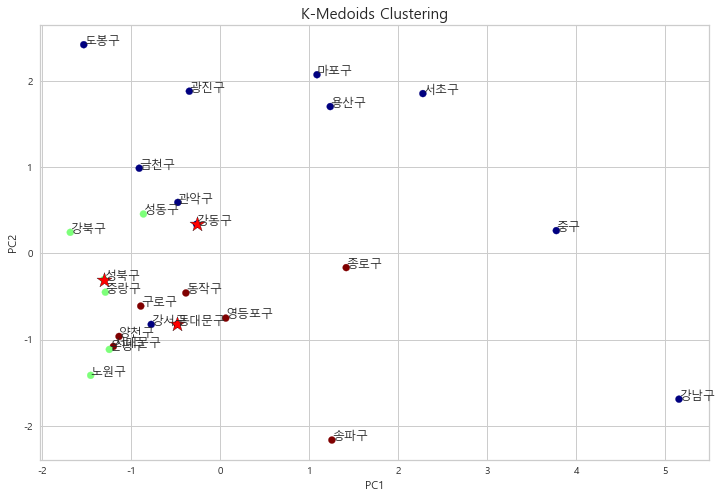

In [56]:
# Kmedoid visualization
# The center of each cluster is marked with *

matplotlib.rcParams['font.family'] ='Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(12,8))
plt.scatter(values_pca[:,0], values_pca[:,1], c=kmedoids.labels_, cmap='jet')
plt.scatter(kmedoids.cluster_centers_[:3, 0], kmedoids.cluster_centers_[:3, 1], s=250, marker='*', c='red', edgecolor='black',
    label='centroids'
)
for i in range(len(principalDf)): 
    row = principalDf.iloc[i]
    name = row['DISTRICT'] 
    x = row['PC1'] 
    y = row['PC2'] 

    plt.text(x, y, name, size=12)
plt.title('K-Medoids Clustering', size=15)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

- 용산구, 서초구, 도봉구, 마포구, 금천구, 관악구, 광진구, 강남구, 중구, 강서구, 강동구 (CLUSTER=0)
- 노원구, 성북구, 강북구, 중랑구, 강서구, 성동구, 은평구(CLUSTER=1)
- 동대문구, 구로구, 영등포구, 양천구, 서대문구, 송파구, 종로구, 동작구 (CLUSTER=2)

In [57]:
k2cluster0 = df_k2table[df_k2table['CLUSTER'] == 0]
k2cluster1 = df_k2table[df_k2table['CLUSTER'] == 1]
k2cluster2 = df_k2table[df_k2table['CLUSTER'] == 2]

Text(0.5, 1.0, 'ESTATE')

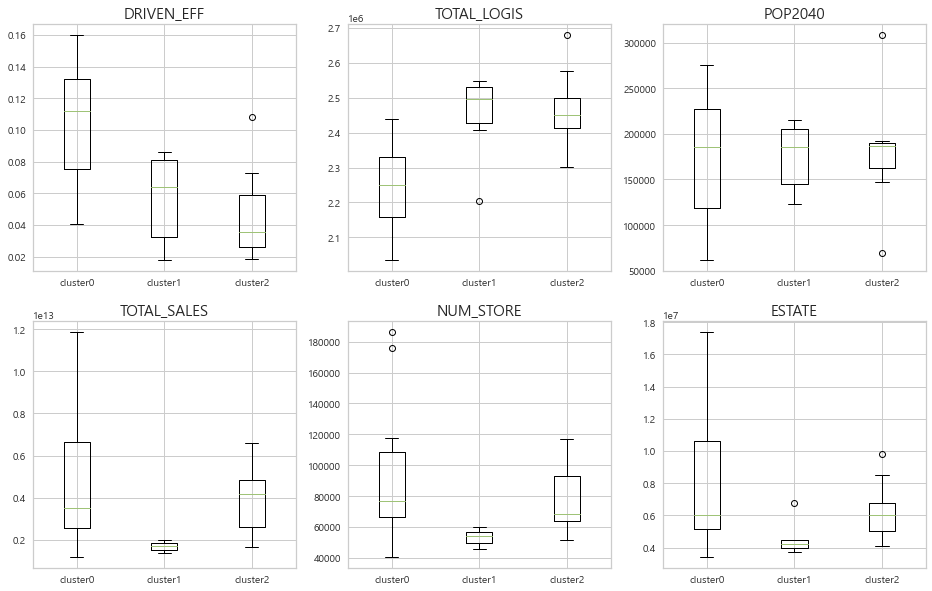

In [58]:
# Boxplot each attributes by clustering group

fig = plt.figure(figsize=(16,10))
ax1 = fig.add_subplot(2,3,1)
ax2 = fig.add_subplot(2,3,2)
ax3 = fig.add_subplot(2,3,3)
ax4 = fig.add_subplot(2,3,4)
ax5 = fig.add_subplot(2,3,5)
ax6 = fig.add_subplot(2,3,6)




ax1.boxplot([k2cluster0.DRIVEN_EFF, k2cluster1.DRIVEN_EFF, k2cluster2.DRIVEN_EFF], labels=['cluster0','cluster1','cluster2']) # DRIVEN_EFF 비교
ax1.set_title('DRIVEN_EFF', size=15)
ax2.boxplot([k2cluster0.TOTAL_LOGIS, k2cluster1.TOTAL_LOGIS, k2cluster2.TOTAL_LOGIS], labels=['cluster0','cluster1','cluster2'])# TOTAL_LOGIS 비교
ax2.set_title('TOTAL_LOGIS', size=15)
ax3.boxplot([k2cluster0.POP2040, k2cluster1.POP2040, k2cluster2.POP2040], labels=['cluster0','cluster1','cluster2'])# POP2040 비교
ax3.set_title('POP2040', size=15)
ax4.boxplot([k2cluster0.TOTAL_SALES, k2cluster1.TOTAL_SALES, k2cluster2.TOTAL_SALES], labels=['cluster0','cluster1','cluster2'])# TOTAL_SALES 비교
ax4.set_title('TOTAL_SALES', size=15)
ax5.boxplot([k2cluster0.NUM_STORE, k2cluster1.NUM_STORE, k2cluster2.NUM_STORE], labels=['cluster0','cluster1','cluster2'])# NUM_STORE 비교
ax5.set_title('NUM_STORE', size=15)
ax6.boxplot([k2cluster0.ESTATE, k2cluster1.ESTATE, k2cluster2.ESTATE], labels=['cluster0','cluster1','cluster2'])# ESTATE 비교
ax6.set_title('ESTATE', size=15)

## K-medoid Clustering Analysis Result
- cluster0
    - 인구수가 가장 많으며 상권과 오프라인 소비력이 가장 크기 때문에 언택트 소비량이 작을 것으로 예상됨
    - 물류량이 가장 작으며 운행 효율이 높기 때문에 현재 물류 서비스가 잘 실행되고 있다고 볼 수 있음
    - 공시지가와 그 폭이 가장 크다 -> MFC 입지에 부적합
   
- cluster1 
    - 물류량, 인구 수 모두 준수
    - 상권 크기가 작으므로 언택트 소비를 기대할 수 있음
    - 공시지가는 가장 낮지만 운행 효율이 cluster2보다 좋음 -> MFC 입지에 괜찮음

- cluster2 
    - 물류량, 인구 수 모두 준수 
    - 공시지가가 cluster1보다 높지만 운행 효율이 가장 낮기 때문에 물류 서비스가 잘 되고 있지 않음 -> MFC 입지에 가장 적합

#### 따라서 cluster2이 MFC입지에 가장 적합

In [59]:
# Extract the appropriate district name for MFC location
k2cluster2.DISTRICT.unique()

array(['동대문구', '구로구', '영등포구', '양천구', '서대문구', '송파구', '종로구', '동작구'],
      dtype=object)

## GMM(Gausian Mixture Model)

In [60]:
# Using GMM clustering
from matplotlib import patches
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

from sklearn.mixture import GaussianMixture 
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn import metrics

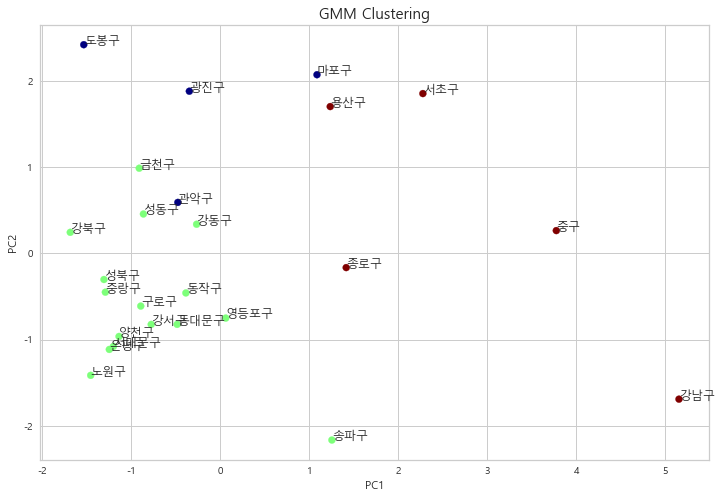

In [61]:
# GMM visualization

gmm = GaussianMixture(n_components=3, random_state=100)
gmm.fit(values_pca) # GMM 클러스터링 수행
labels = gmm.predict(values_pca) # 최종 클러스터 라벨링

matplotlib.rcParams['font.family'] ='Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False
fig = plt.figure(figsize=(12,8))
fig.set_facecolor('white')
plt.scatter(values_pca[:,0], values_pca[:,1], c=labels, cmap='jet')

for i in range(len(principalDf)): 
    row = principalDf.iloc[i]
    name = row['DISTRICT'] 
    x = row['PC1'] 
    y = row['PC2'] 

    plt.text(x, y, name, size=12)
plt.title('GMM Clustering', size=15)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

- 마포구, 강북구, 도봉구, 금천구(CLUSTER=0)
- 동대문구, 구로구, 노원구,성북구, 강북구, 금천구, 영등포구, 중랑구, 양천구, 서대문구, 송파구, 강서구, 강동구, 성동구, 동작구, 은평구 (CLUSTER=1)
- 용산구, 서초구, 강남구, 중구, 종로구(CLUSTER=2)

In [62]:
labels

array([1, 2, 1, 1, 2, 0, 1, 1, 0, 1, 1, 1, 0, 0, 2, 2, 1, 1, 1, 1, 1, 2,
       1, 1, 1], dtype=int64)

In [63]:
# GMM clustering labeling
df_gtable = df_table.copy()
df_gtable['CLUSTER'] = labels
df_gtable

,DISTRICT,DRIVEN_EFF,TOTAL_LOGIS,POP2040,TOTAL_SALES,NUM_STORE,ESTATE,CLUSTER
0,동대문구,0.027219,2400374,166805,4.447564e+12,66655,5198000,1
1,용산구,0.131360,2250955,112398,6.805869e+12,62840,10079000,2
2,구로구,0.054334,2442377,184583,2.806535e+12,69651,4109000,1
3,노원구,0.026526,2507172,215172,1.834499e+12,57391,3911000,1
4,서초구,0.159699,2165093,185381,6.456707e+12,117682,11141000,2
5,마포구,0.142776,2067762,191766,4.087616e+12,99849,9213000,0
6,성북구,0.082233,2484878,199990,1.380648e+12,52834,4507000,1
7,강북구,0.017854,2202978,122596,1.482913e+12,48726,3705000,1
8,도봉구,0.111866,2034893,126118,1.210447e+12,40786,3451000,0
9,금천구,0.066146,2201708,111478,3.490343e+12,55524,3870000,1


In [64]:
gcluster0 = df_gtable[df_gtable['CLUSTER'] == 0]
gcluster1 = df_gtable[df_gtable['CLUSTER'] == 1]
gcluster2 = df_gtable[df_gtable['CLUSTER'] == 2]

Text(0.5, 1.0, 'ESTATE')

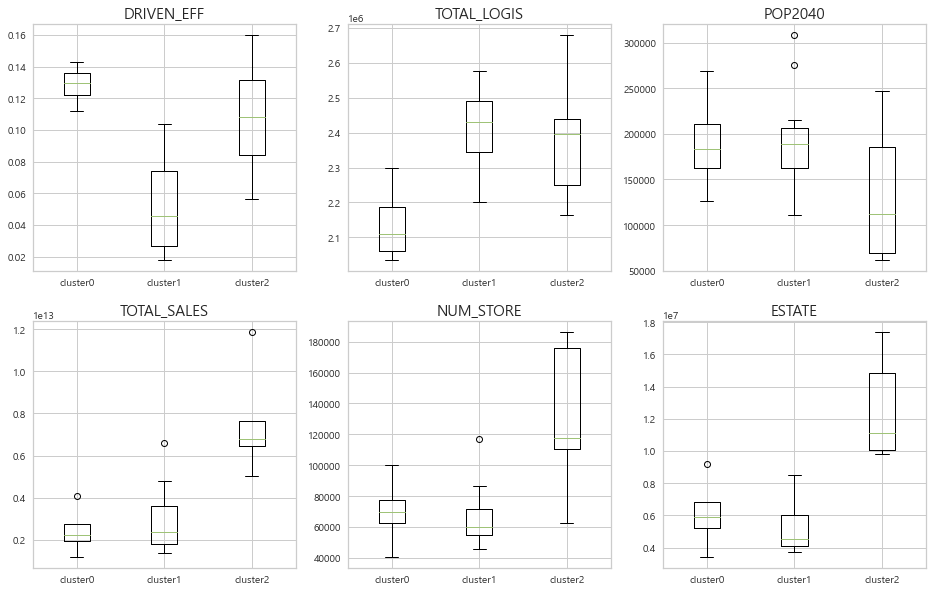

In [65]:
# Boxplot each attributes by clustering group

fig = plt.figure(figsize=(16,10))
ax1 = fig.add_subplot(2,3,1)
ax2 = fig.add_subplot(2,3,2)
ax3 = fig.add_subplot(2,3,3)
ax4 = fig.add_subplot(2,3,4)
ax5 = fig.add_subplot(2,3,5)
ax6 = fig.add_subplot(2,3,6)



ax1.boxplot([gcluster0.DRIVEN_EFF, gcluster1.DRIVEN_EFF, gcluster2.DRIVEN_EFF], labels=['cluster0','cluster1','cluster2']) # DRIVEN_EFF 비교
ax1.set_title('DRIVEN_EFF', size=15)
ax2.boxplot([gcluster0.TOTAL_LOGIS, gcluster1.TOTAL_LOGIS, gcluster2.TOTAL_LOGIS], labels=['cluster0','cluster1','cluster2'])# TOTAL_LOGIS 비교
ax2.set_title('TOTAL_LOGIS', size=15)
ax3.boxplot([gcluster0.POP2040, gcluster1.POP2040, gcluster2.POP2040], labels=['cluster0','cluster1','cluster2'])# POP2040 비교
ax3.set_title('POP2040', size=15)
ax4.boxplot([gcluster0.TOTAL_SALES, gcluster1.TOTAL_SALES, gcluster2.TOTAL_SALES], labels=['cluster0','cluster1','cluster2'])# TOTAL_SALES 비교
ax4.set_title('TOTAL_SALES', size=15)
ax5.boxplot([gcluster0.NUM_STORE, gcluster1.NUM_STORE, gcluster2.NUM_STORE], labels=['cluster0','cluster1','cluster2'])# NUM_STORE 비교
ax5.set_title('NUM_STORE', size=15)
ax6.boxplot([gcluster0.ESTATE, gcluster1.ESTATE, gcluster2.ESTATE], labels=['cluster0','cluster1','cluster2'])# ESTATE 비교
ax6.set_title('ESTATE', size=15)

## GMM Clustering Analysis Result

- cluster0
    - 공시지가는 낮고 인구수는 준수 
    - 물동량이 가장 작으며 운행 효율이 높기 때문에 이미 물류 서비스율이 높다고 할 수 있음 -> MFC 입지에 부적합

- cluster1
    - 물동량 및 인구수 준수
    - 상권 크기가 작아 언택트 소비를 기대할 수 있음
    - 공시지가도 낮으며 운행 효율이 낮은 값임 -> MFC 입지에 적합

- cluster2 
    - 물동량이 준수하지만 그 폭이 너무 넓기 때문에 수요가 일정하지 않음
    - 운행 효율이 높고 공시지가가 너무 높음 -> MFC 입지에 부적합

#### 따라서 cluster1이 MFC 입지에 가장 적합

In [66]:
# Extract the appropriate district name for MFC location
gcluster1.DISTRICT.unique()

array(['동대문구', '구로구', '노원구', '성북구', '강북구', '금천구', '영등포구', '중랑구', '양천구',
       '서대문구', '송파구', '강서구', '강동구', '성동구', '동작구', '은평구'], dtype=object)

## Consensus (Merge results from 4 clustering methods)

In [67]:
# Number of selected clustering groups (hierarchy)
hcluster1.DISTRICT.unique()

array(['동대문구', '구로구', '노원구', '성북구', '강북구', '영등포구', '중랑구', '관악구', '양천구',
       '서대문구', '송파구', '강서구', '강동구', '동작구', '은평구'], dtype=object)

In [68]:
# Number of selected clustering groups (kmeans)
kcluster0.DISTRICT.unique()

array(['동대문구', '구로구', '노원구', '성북구', '강북구', '금천구', '영등포구', '중랑구', '관악구',
       '양천구', '서대문구', '송파구', '강서구', '강동구', '성동구', '동작구', '은평구'],
      dtype=object)

In [69]:
# Number of selected clustering groups (kmedoid)
k2cluster2.DISTRICT.unique()

array(['동대문구', '구로구', '영등포구', '양천구', '서대문구', '송파구', '종로구', '동작구'],
      dtype=object)

In [70]:
# Number of selected clustering groups (GMM)
gcluster1.DISTRICT.unique()

array(['동대문구', '구로구', '노원구', '성북구', '강북구', '금천구', '영등포구', '중랑구', '양천구',
       '서대문구', '송파구', '강서구', '강동구', '성동구', '동작구', '은평구'], dtype=object)

In [71]:
consensus = hcluster1.DISTRICT.unique().tolist() + kcluster0.DISTRICT.unique().tolist() + k2cluster2.DISTRICT.unique().tolist() + gcluster1.DISTRICT.unique().tolist()

[Text(0.5, 1.0, 'Consensus Clustering')]

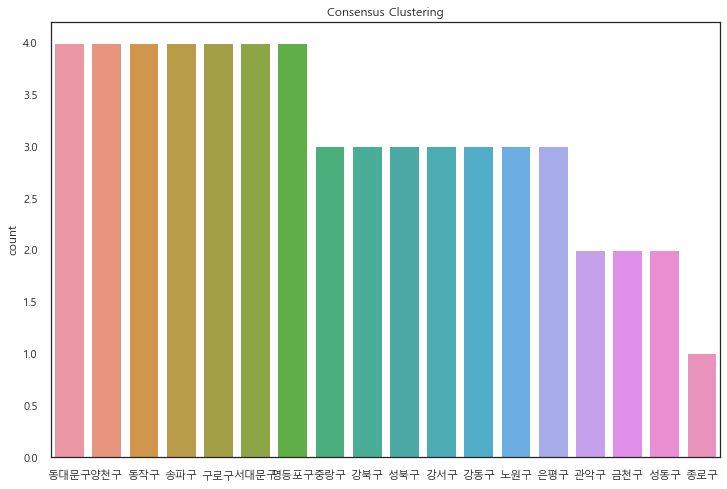

In [72]:
import seaborn as sns
sns.set(font="Malgun Gothic",
rc={"axes.unicode_minus":False, 'figure.figsize':(12,8)}, style='white')
sns.countplot(consensus, order = pd.Series(consensus).value_counts().index).set(title='Consensus Clustering')

#### '동대문구', '양천구', '동작구', '송파구', '구로구', '서대문구', '영등포구' is the best candidate district for MFC

**<center>Rank(Candidate District where will be installed MFC)</center>**

|1st|2nd|3rd|4rd|
|------|------|------|------|
|Guro|Dongdaemun|Gwanak|Songpa|
|Nowon|Gangseo|Gwangjin|Yeongdeungpo|
|Dongjak|Eunpyeong|Gangdong|
|Yangcheon|Seongdong||
|Seodaemun|Jungnang||
||Gangbuk||
||Seongbuk||

In [73]:
import pandas_profiling as pp 

profile = pp.ProfileReport(df_scaling)
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [74]:
df_scaling.corr(method='pearson', min_periods=1)

,DRIVEN_EFF,TOTAL_LOGIS,POP2040,TOTAL_SALES,NUM_STORE,ESTATE
DRIVEN_EFF,1.000000,-0.439050,-0.229005,0.097086,0.107439,0.300083
TOTAL_LOGIS,-0.439050,1.000000,0.021584,-0.003943,0.062162,0.023607
POP2040,-0.229005,0.021584,1.000000,0.037811,0.071460,-0.091921
TOTAL_SALES,0.097086,-0.003943,0.037811,1.000000,0.874121,0.909956
NUM_STORE,0.107439,0.062162,0.071460,0.874121,1.000000,0.907962
ESTATE,0.300083,0.023607,-0.091921,0.909956,0.907962,1.000000
